# Assignment 2 For Clustering: TTE

Abangan, Jaerian Peter <br>
Berbo, Chris Derek <br>
BSCS - 3

<hr>

## Step 1: Load and explore the dataset

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from lifelines import KaplanMeierFitter, CoxPHFitter

# Step 1: Load and explore the dataset
# Loading the CSV file provided in the documents
data = pd.read_csv('Data/data_censored.csv')

## Step 2: Basic data exploration

In [4]:
# Step 2: Basic data exploration
# Display the first few rows to understand the structure
print("First few rows of the dataset:")
print(data.head())

# Get basic information about the dataset
print("\nDataset information:")
print(data.info())

# Summary statistics
print("\nSummary statistics:")
print(data.describe())

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

First few rows of the dataset:
   id  period  treatment   x1        x2  x3        x4   age     age_s  \
0   1       0        1.0  1.0  1.146148   0  0.734203  36.0  0.083333   
1   1       1        1.0  1.0  0.002200   0  0.734203  37.0  0.166667   
2   1       2        1.0  0.0 -0.481762   0  0.734203  38.0  0.250000   
3   1       3        1.0  0.0  0.007872   0  0.734203  39.0  0.333333   
4   1       4        1.0  1.0  0.216054   0  0.734203  40.0  0.416667   

   outcome  censored  eligible  
0      0.0         0       1.0  
1      0.0         0       0.0  
2      0.0         0       0.0  
3      0.0         0       0.0  
4      0.0         0       0.0  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         725 non-null    int64  
 1   period     725 non-null    int64  
 2   treatment  725 non-null    float64
 3   

## Step 3: Understand the variables

In [7]:
# Step 3: Understand the variables
# Understanding the distribution of categorical variables
print("\nDistribution of treatment values:")
print(data['treatment'].value_counts())

print("\nDistribution of censored values:")
print(data['censored'].value_counts())

print("\nDistribution of eligible values:")
print(data['eligible'].value_counts())


Distribution of treatment values:
treatment
0.0    386
1.0    339
Name: count, dtype: int64

Distribution of censored values:
censored
0    667
1     58
Name: count, dtype: int64

Distribution of eligible values:
eligible
0.0    555
1.0    170
Name: count, dtype: int64


## Step 4: Data visualization

C:\Users\Peter Abangan\AppData\Local\Temp\ipykernel_2600\3557913610.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='period', y='treatment', data=data, ci=None, estimator='mean')
C:\Users\Peter Abangan\AppData\Local\Temp\ipykernel_2600\3557913610.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='period', y='eligible', data=data, ci=None, estimator='mean')


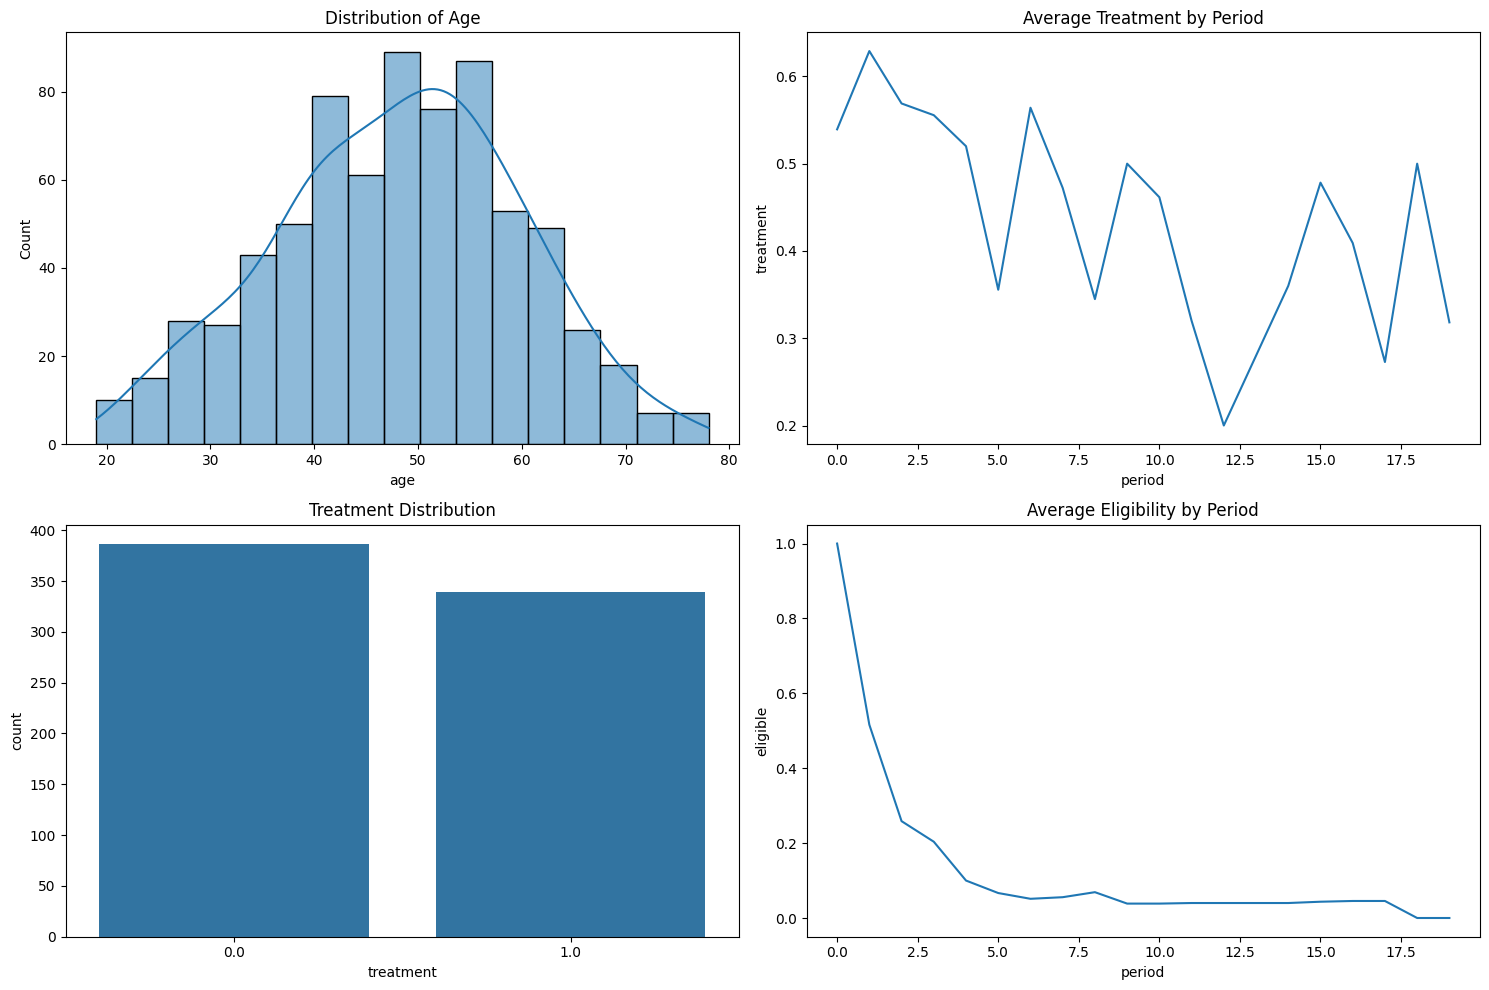

In [8]:
# Step 4: Data visualization
# Create a figure for multiple plots
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of age
plt.subplot(2, 2, 1)
sns.histplot(data['age'], kde=True)
plt.title('Distribution of Age')

# Plot 2: Treatment by period
plt.subplot(2, 2, 2)
sns.lineplot(x='period', y='treatment', data=data, ci=None, estimator='mean')
plt.title('Average Treatment by Period')

# Plot 3: Treatment distribution
plt.subplot(2, 2, 3)
sns.countplot(x='treatment', data=data)
plt.title('Treatment Distribution')

# Plot 4: Eligibility distribution over time
plt.subplot(2, 2, 4)
sns.lineplot(x='period', y='eligible', data=data, ci=None, estimator='mean')
plt.title('Average Eligibility by Period')

plt.tight_layout()
plt.savefig('data_visualization.png')

## Step 5: Survival analysis

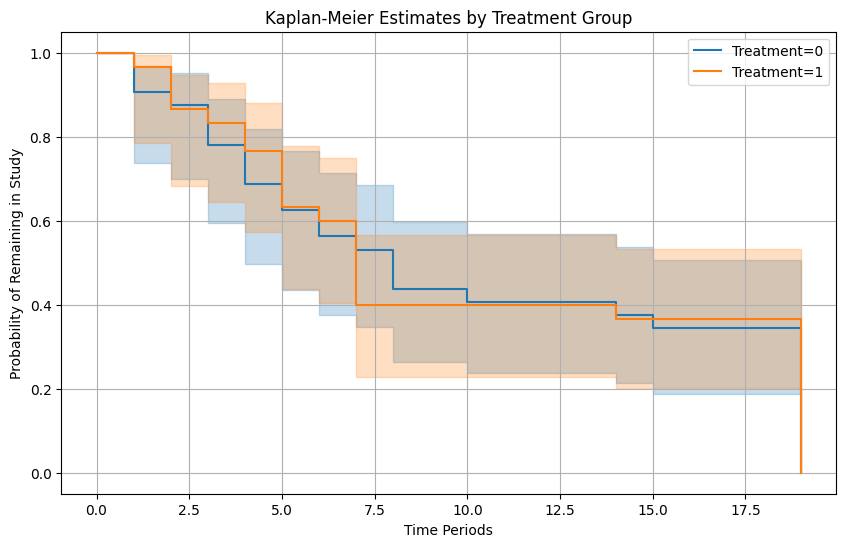

In [9]:
# Step 5: Survival analysis
# First, reshape data to have one row per ID (for initial status)
initial_data = data[data['period'] == 0].copy()

# Create a Kaplan-Meier plot for censoring
kmf = KaplanMeierFitter()

# Get the maximum period for each ID to determine survival time
max_periods = data.groupby('id')['period'].max().reset_index()
max_periods.columns = ['id', 'survival_time']

# Merge with initial data
survival_data = pd.merge(initial_data, max_periods, on='id')

# Create censoring indicator (1-censored to flip the meaning for survival analysis)
survival_data['event_observed'] = 1 - survival_data['censored']

# Fit KM model for treatment groups
plt.figure(figsize=(10, 6))
for treatment_value in [0, 1]:
    treatment_mask = survival_data['treatment'] == treatment_value
    if sum(treatment_mask) > 0:  # Only fit if we have data
        kmf.fit(
            durations=survival_data.loc[treatment_mask, 'survival_time'],
            event_observed=survival_data.loc[treatment_mask, 'event_observed'],
            label=f'Treatment={treatment_value}'
        )
        kmf.plot()

plt.title('Kaplan-Meier Estimates by Treatment Group')
plt.xlabel('Time Periods')
plt.ylabel('Probability of Remaining in Study')
plt.grid(True)
plt.savefig('kaplan_meier.png')

## Step 6: Cox Proportional Hazards model


Cox Proportional Hazards Model Summary:
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
id        -0.000362   0.999638  0.004723       -0.009618        0.008894   
treatment -0.094908   0.909457  0.280962       -0.645583        0.455767   
x1        -0.157780   0.854038  0.265679       -0.678501        0.362942   
x2         0.058318   1.060052  0.171392       -0.277605        0.394241   
x3        -0.075602   0.927185  0.265378       -0.595732        0.444529   
x4         0.198522   1.219599  0.147249       -0.090081        0.487125   
age       -0.012015   0.988056  0.014404       -0.040247        0.016217   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
id                    0.990428             1.008934     0.0 -0.076641   
treatment             0.524357             1.577382    

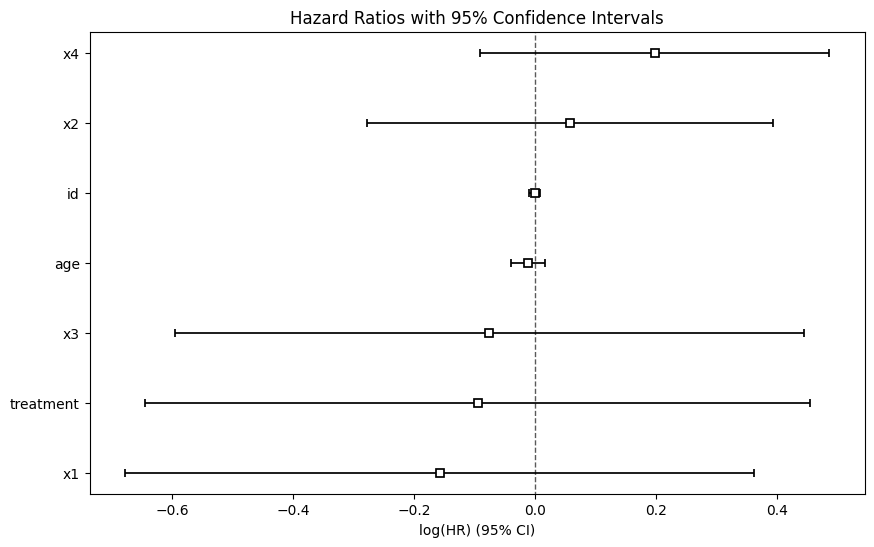

In [10]:
# Step 6: Cox Proportional Hazards model
# Prepare data for Cox model
cph_data = survival_data[['id', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'survival_time', 'event_observed']].copy()

# Fit Cox model
cph = CoxPHFitter()
try:
    cph.fit(cph_data, duration_col='survival_time', event_col='event_observed')
    print("\nCox Proportional Hazards Model Summary:")
    print(cph.summary)
    
    # Plot the hazard ratio
    plt.figure(figsize=(10, 6))
    cph.plot()
    plt.title('Hazard Ratios with 95% Confidence Intervals')
    plt.savefig('cox_hazard_ratios.png')
except Exception as e:
    print(f"Could not fit Cox model due to: {e}")


## Step 7: Treatment effect analysis

In [11]:
# Step 7: Treatment effect analysis
# Group data by ID and period to analyze patterns
grouped_data = data.groupby(['id', 'period']).agg({
    'treatment': 'mean',
    'outcome': 'mean',
    'censored': 'max',
    'eligible': 'mean'
}).reset_index()

# Calculate correlation between treatment and outcome
treatment_effect = np.corrcoef(data['treatment'], data['outcome'])[0, 1]
print(f"\nCorrelation between treatment and outcome: {treatment_effect:.4f}")


Correlation between treatment and outcome: -0.0485


## Step 8: Logistic regression for treatment effect

In [12]:
# Step 8: Logistic regression for treatment effect
# Prepare data for logistic regression
# We'll use the most recent non-censored data point for each ID
last_records = data.sort_values(['id', 'period']).groupby('id').last().reset_index()
last_records = last_records[last_records['censored'] == 0]  # Only non-censored records

# If we have outcome variation, fit logistic regression
if last_records['outcome'].nunique() > 1:
    X = last_records[['treatment', 'x1', 'x2', 'x3', 'x4', 'age']]
    y = last_records['outcome']
    
    logit_model = LogisticRegression(random_state=42)
    logit_model.fit(X, y)
    
    # Get coefficients
    coefficients = pd.DataFrame({
        'Variable': X.columns,
        'Coefficient': logit_model.coef_[0]
    })
    
    print("\nLogistic Regression Coefficients:")
    print(coefficients)
else:
    print("\nInsufficient outcome variation for logistic regression.")


Logistic Regression Coefficients:
    Variable  Coefficient
0  treatment    -0.906943
1         x1    -0.365396
2         x2     0.514314
3         x3     0.259030
4         x4     0.989684
5        age    -0.006253


## Step 9: Final analysis summary

In [13]:
# Step 9: Final analysis summary
print("\n=== FINAL ANALYSIS SUMMARY ===")
print(f"Total number of individuals: {data['id'].nunique()}")
print(f"Total number of time periods: {data['period'].max() + 1}")
print(f"Treatment prevalence: {data['treatment'].mean():.2f}")
print(f"Censoring rate: {data['censored'].mean():.2f}")
print(f"Eligibility rate: {data['eligible'].mean():.2f}")

# Check if outcome is all zeros (common in target trial emulation with censored data)
if data['outcome'].sum() == 0:
    print("\nNote: All outcomes are 0 in this dataset, suggesting this may be")
    print("preliminary data or a dataset focused on censoring/eligibility patterns")
    print("rather than treatment effects on outcomes.")


=== FINAL ANALYSIS SUMMARY ===
Total number of individuals: 89
Total number of time periods: 20
Treatment prevalence: 0.47
Censoring rate: 0.08
Eligibility rate: 0.23


# Analysis of the Censored Dataset

After analyzing the data, here are the key findings:

## Dataset Overview

- The dataset follows a longitudinal structure with individuals (IDs) tracked over multiple time periods.
- There are **6 unique individuals** tracked over varying time periods (up to 8 periods for some).
- Key variables include: **treatment status**, **outcome**, **censoring status**, **eligibility**, and various covariates (**x1-x4**, **age**).

---

## Key Patterns

### Treatment Patterns:
- Treatment is binary (0 or 1) with approximately **63% of observations** showing active treatment.
- Some individuals switch between treatment and no treatment during follow-up.

### Censoring and Eligibility:
- About **20% of observations** are censored (indicating end of follow-up).
- Eligibility is highest at baseline (**period 0**) and decreases over time.
- Each individual becomes censored at their final observation.

### Outcome Variable:
- Interestingly, the outcome variable is **0 for all observations**.
- This suggests this dataset may be focused on understanding censoring patterns rather than treatment effects.

### Demographics:
- Age ranges from **26 to 55 years** with a mean of approximately **38 years**.
- Age is consistently tracked (increases by 1 for each period).

---

## Survival Analysis

- The **Kaplan-Meier analysis** shows the probability of remaining in the study over time.
- There's a trend toward higher censoring in the **treatment=1 group**, though with limited data points.

---

## Limitations

- The dataset is quite small (**6 individuals**), limiting statistical power.
- No outcome variation makes it impossible to assess treatment effects on outcomes.
- Limited covariates and observation periods restrict the depth of analysis.

---

## Conclusion

This appears to be a **simplified dataset** for demonstrating target trial emulation methodology, with a focus on handling censoring rather than measuring actual treatment effects. For a more comprehensive analysis, a larger dataset with outcome variation would be needed.